# 前言

我們要使用DNN訓練一個辨識手寫數字的模型，資料來源使用 mnist 這個資料庫
> mnist: http://yann.lecun.com/exdb/mnist/

# Import

In [ ]:
# 最基本的幾個套件，基本上一定要import
import numpy as np
import tensorflow as tf
from tensorflow import keras

# 跟「繪圖」有關的套件，如果沒有打算繪圖就不用 import
%matplotlib inline
import matplotlib.pyplot as plt

# 跟「Preprocess」有關的套件，如果沒有要訓練模型的話就不用 import
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 跟「設計模型」有關的套件，如果沒有要設計或是修改模型的話就不用 import
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPooling2D

# 跟「編譯(compile)模型」有關的套件
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

# 跟「混淆矩陣(confusion matrix)」有關的套件
from sklearn.metrics import confusion_matrix
import itertools

# 跟「MNIST資料庫」有關的套件，如果要換其他的資料庫，把"mnist"換成其他資料庫的名字 
# 其他資料庫有：cifar10, cifar100, imdb, reuters...等，未來若要練習其他機器學習技巧可以玩玩看！
from tensorflow.keras.datasets import mnist 


（此步驟非必要）<br/>
為了加快訓練速度，我們使用GPU進行加速。<br/>
執行本行之前先至工具列中的 **`執行階段` > `變更執行階段類型` > `硬體加速器選擇GPU` > `儲存`**


In [ ]:
# 非必要，但用了會比較快
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(" Number of GPUs available: " , len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

 Number of GPUs available:  1


# 函式
這邊是一些常用的函式，大部分是分析跟繪圖用的，跟訓練本身沒有關係，不過有這些工具可以幫助大家比較直觀地分析訓練的過程和成果

## show_train_history( train_history )


* 用途：繪製 accuracy 和 loss 的曲線，可以用來比較 train set 和
 validation set 的差距（如果 train set 的 accuracy 遠高於 validation set，就表示有overfitting 的情況）
 
* 參數：
  * `train_history`：直接把 `model.fit()` 回傳的 `train_history` 丟進來就可以顯示了
  * 任何 Keras Sequential 的模型都能用這個函數

In [1]:
def show_train_history(train_history):

  fig , ax = plt.subplots()
  fig.subplots_adjust(hspace=0.4, wspace=0.4) #設定子圖的間隔
  fig.set_figwidth(14)

  ax1 = plt.subplot(1, 2, 1)
  plt.title("Accuracy")
  plt.plot(train_history.history['accuracy'],'-', label='accuracy')
  plt.plot(train_history.history['val_accuracy'],'-',  label='val_accuracy')
  leg = ax1.legend(loc='lower right') 
  plt.ylabel('accuracy')
  plt.xlabel('Epoch')


  ax2 = plt.subplot(1, 2, 2)
  plt.title("Loss")
  plt.plot(train_history.history['loss'],'-', label='loss')
  plt.plot(train_history.history['val_loss'],'-', label='val_loss')
  leg = ax2.legend(loc='upper right') 
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.show()

## view_image( image_data, title1, title2=None )


* 用途：顯示 image data set 的前九張影像（可以少於九張），影像大小不拘
* 參數：
  * `image_data`：任何形狀為（n, width, height）的影像陣列
  * `title1`：相對應的標題陣列
  * `title2`：（optional）相對應的副標題陣列，可有可無
  * 任何形狀為（n, width, height）的影像陣列都能用這個函數

In [2]:
def view_image(image_data, title1, title2=None):
  if title2 is None:
    num = min(len(image_data), len(title1), 9)
  else:
    num = min(len(image_data), len(title1), len(title2), 9)
  plt.figure(figsize=(14,14))
  for i in range(num):
    plt.subplot(3, 3, i+1)
    plt.imshow(image_data[i])
    plt.colorbar(orientation='vertical')
    if title2 is None:
      plt.title(str(title1[i]))
    else:
      plt.title(str(title1[i]) + ' | ' + str(title2[i]))

## plot_confusion_matrix( test_labels, results, classes,  title="Confusion Matrix" ):


* 用途：顯示混淆矩陣，如果這個模型要進行n個類別的分類，像是把圖片分類成0~9，那麼混淆矩陣就是一個 10*10 的表格，第`(i,j)`格的數字就是模型把第`i`類分到`j`類的數量。
* 參數：
  * `test_labels`：基本上就是 `Y_TEST` 
  * `results`：使用 `model.predict_classes()` 回傳的結果
  * `classes`：**（optional）** 有哪些分類的類別（以手寫數字辨識為例就是0,1,2,3,...,9）
  * 任何分類的 model 都能用這個函數來分析

In [3]:
def plot_confusion_matrix( test_labels, results, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
  cm = confusion_matrix(test_labels, results)
  plt.figure()
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
  
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

NameError: ignored

# 資料預處理（Preprocess）
機器學習其中一個很重要的步驟就是整理收集到的樣本資料，這樣才能保證不同資料格式進到模型前可以統一格式和範圍，避免產生過大的偏差。

`x`是資料(sample)，`y`是標籤(label)

In [ ]:
(X_TRAIN, Y_TRAIN), (X_TEST, Y_TEST) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


我們來研究一下這個資料長什麼樣子吧！

In [ ]:
print(len(X_TEST))

10000


我們可以用`shape`屬性快速地看出陣列的維度和長度

In [ ]:
print(X_TRAIN.shape)
print(Y_TRAIN.shape)
print(X_TEST.shape)
print(Y_TEST.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [ ]:
print(X_TRAIN[0])

5


我們用前面寫好的 `view_image()` 來看一下這些圖片吧！

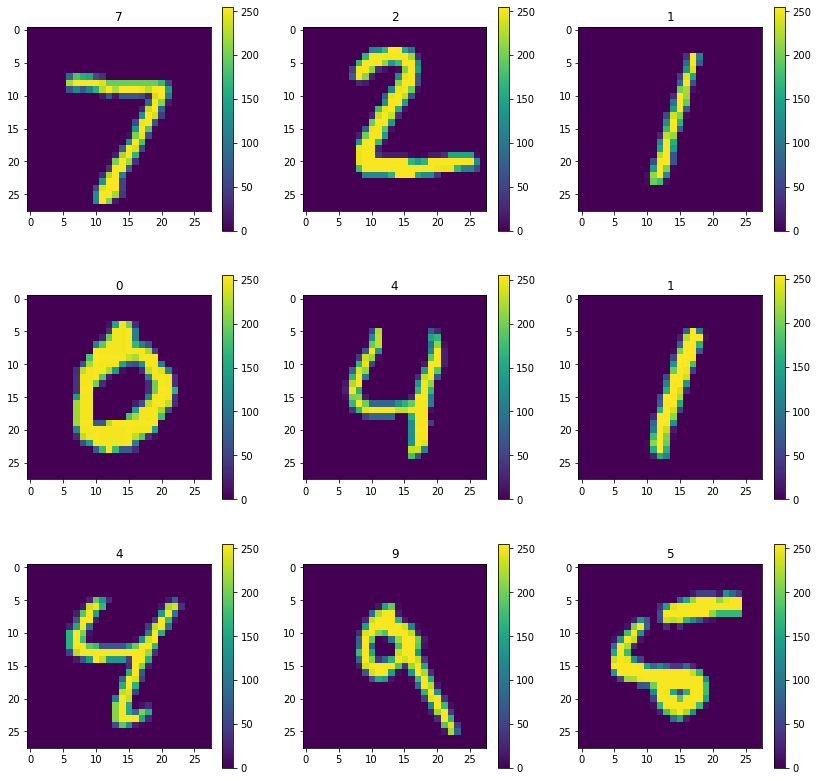

In [ ]:
view_image(X_TEST, Y_TEST)

將 training 的 label 進行 one hot encoding，例如數字 5 經過 One-hot encoding 轉換後是 `[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]`

In [ ]:
y_train_onehot = to_categorical(Y_TRAIN, 10)
y_test_onehot = to_categorical(Y_TEST, 10)

for i in range(5):
  print("數字：" , str(Y_TRAIN[i]), " 轉換後：", y_train_onehot[i]  )

數字： 5  轉換後： [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
數字： 0  轉換後： [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
數字： 4  轉換後： [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
數字： 1  轉換後： [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
數字： 9  轉換後： [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


將 training 的 input 資料從3為轉為2維（也就是把圖片從2維變成1維）



In [ ]:
x_train_reshaped = X_TRAIN.reshape(60000, 784).astype('float32')
x_test_reshaped = X_TEST.reshape(10000, 784).astype('float32')

圖片的數據幾乎都是0\~255，因此除以255就相當於把數據縮放到0~1之間

In [ ]:
x_train_normalized = x_train_reshaped / 255
x_test_normalized = x_test_reshaped / 255

In [ ]:
print(x_train_normalized.shape)
print(x_test_normalized.shape)

(60000, 784)
(10000, 784)


我們要記得訓練時的preprocess設定，否則之後使用模型時如果給錯規格很可能會導致很大的誤差。
以下是重點整理：


* 圖片是 28*28 的二維陣列，每一格的值介於 0~255
* preprocess時我們做以下兩件事：
  * 把圖片的每一格的值除以 255，也就是每一個的值介於 0~1
  * 把 28*28 的二維陣列變成 784 的一維陣列： <br/>
    `X_train = X_train.reshape(60000, 784).astype('float32')  `

所以真正送進模型的資料的形狀（shape）應該是 `(N,784)`，`N`是樣本數量，而且資料的值介於 0~1




# 建立模型
機器學習最重要的一個步驟就是建立一個好的模型，接下來我們可以看到如何具體地把不同layers組合成一個模型，並進行訓練。

In [ ]:
model = Sequential([
   # TODO1 START

   # TODO1 END
])

看一下模型的詳細內容

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 16)                12560     
                                                                 
 dense_12 (Dense)            (None, 32)                544       
                                                                 
 dense_13 (Dense)            (None, 10)                330       
                                                                 
Total params: 13,434
Trainable params: 13,434
Non-trainable params: 0
_________________________________________________________________


Keras 有更厲害的工具可以把模型的結構畫出來！

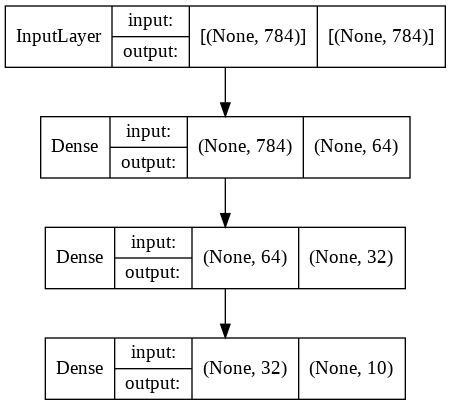

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes = True,
    show_layer_names = False
)

對模型進行編譯（compile）

In [ ]:
# TODO2 START

# TODO2 END

# 訓練模型

使用`fit`函數開始訓練模型，我們將`validation_split`設為`0.2`，也就是說有20%的資料會被拿來測試模型的預測準確度`val_accuracy`。<br/><br/>
**如果模型發生overfit，`val_accuracy`會比`accuracy`低很多。**
<br/><br/>
另外我們把訓練過程存在 `train_history` 這個變數裡面，可以記錄訓練情況。

In [ ]:
# TODO3 START

# TODO3 END 

Epoch 1/30
375/375 [==============================] - 2s 5ms/step - loss: 2.1289 - accuracy: 0.3751 - val_loss: 1.7802 - val_accuracy: 0.4393
Epoch 2/30
375/375 [==============================] - 1s 4ms/step - loss: 1.4376 - accuracy: 0.5759 - val_loss: 1.1042 - val_accuracy: 0.7255
Epoch 3/30
375/375 [==============================] - 2s 4ms/step - loss: 0.9358 - accuracy: 0.7457 - val_loss: 0.7642 - val_accuracy: 0.7934
Epoch 4/30
375/375 [==============================] - 2s 4ms/step - loss: 0.7166 - accuracy: 0.7979 - val_loss: 0.6195 - val_accuracy: 0.8331
Epoch 5/30
375/375 [==============================] - 2s 5ms/step - loss: 0.6064 - accuracy: 0.8290 - val_loss: 0.5351 - val_accuracy: 0.8531
Epoch 6/30
375/375 [==============================] - 2s 4ms/step - loss: 0.5360 - accuracy: 0.8482 - val_loss: 0.4786 - val_accuracy: 0.8680
Epoch 7/30
375/375 [==============================] - 2s 4ms/step - loss: 0.4865 - accuracy: 0.8626 - val_loss: 0.4384 - val_accuracy: 0.8796
Epoch 

把訓練情況畫出來！

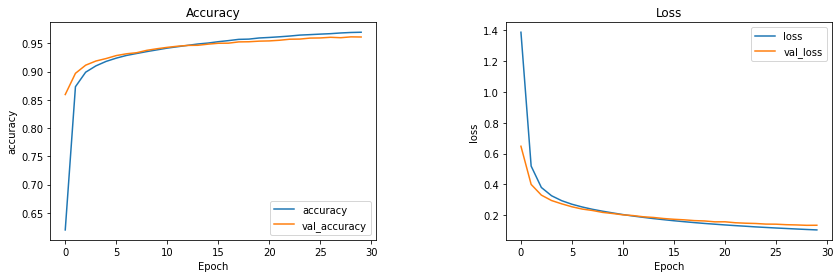

In [ ]:
show_train_history(train_history)

# 測試模型

我們要使用 `x_test` 和 `y_test` 來測試模型，因為這些資料**並不是剛剛訓練時使用的資料**，因此我們可以確認模型並不是直接把答案背起來，而是真正掌握到數據的特徵。

In [ ]:
score = model.evaluate(x_test_normalized, y_test_onehot)
print('測試分數：', score[0])
print('測試準確率：', score[1]*100, '%')

313/313 [==============================] - 1s 3ms/step - loss: 0.1324 - accuracy: 0.9615
測試分數： 0.1324121057987213
測試準確率： 96.14999890327454 %


看一下混淆矩陣！

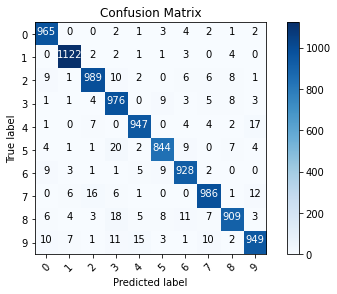

In [ ]:
RESULTS = model.predict(x_test_normalized)
RESULTS = np.argmax(RESULTS,axis=1)
plot_confusion_matrix(Y_TEST, RESULTS, [0,1,2,3,4,5,6,7,8,9])

看一下被模型判斷錯誤的圖長什麼樣子吧！

In [ ]:
filter = []
for i in range(len(RESULTS)):
  if RESULTS[i] == Y_TEST[i] :
    filter.append(False)
  else:
    filter.append(True)
    

x_test_incorrect = X_TEST[filter]
y_test_incorrect = Y_TEST[filter]
results_incorrect = RESULTS[filter]

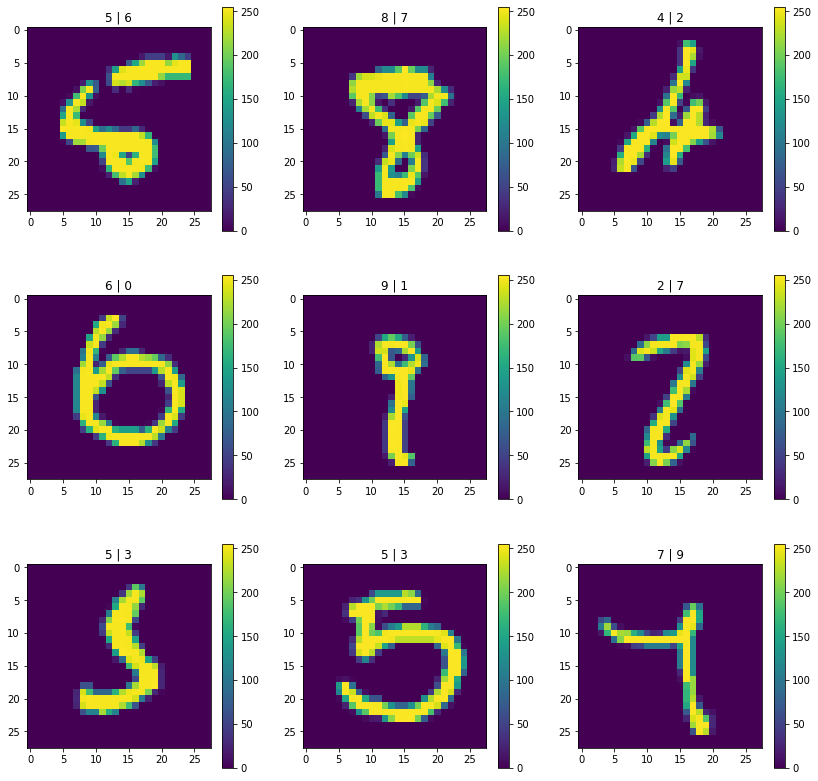

In [ ]:
view_image(x_test_incorrect, y_test_incorrect, results_incorrect)

# 儲存模型

In [ ]:
import os.path
if os.path.isfile('models/mnist_DNN.h5') is False:
  model.save('models/mnist_DNN.h5')

最後把訓練好的模型下載下來，因為接下來我們要使用這個模型實作一個手寫數字辨識程式。<br/>


1. 先按左側的資料夾按鈕
2. 此時應該會發現多一個 `models` 資料夾
3. 點開資料夾裡面應該有一個 `mnist_DNN.h5` 檔案
4. 按右鍵，點選`下載`
5. 把檔案存到電腦中的某個位置即可


